In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
import mlsmote
from skmultilearn.problem_transform import BinaryRelevance
import json
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
from tqdm import tqdm
from inspect import signature
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,hamming_loss

In [2]:
# Load the dataset
data = pd.read_csv('ai4i2020.csv',index_col=None)


In [3]:
no_data_entries = data.shape[0]
repetition_class_ratio= data[['TWF','HDF','PWF','OSF','RNF']].sum(axis=0)/no_data_entries
print(repetition_class_ratio)

TWF    0.0046
HDF    0.0115
PWF    0.0095
OSF    0.0098
RNF    0.0019
dtype: float64


In [4]:
non_failure_samples_no= no_data_entries-data[["Machine failure"]].sum(axis=0).values[0]
print(non_failure_samples_no)

9661


In [ ]:
classifiers = [
    XGBClassifier,
    LGBMClassifier,
    CatBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    LogisticRegression,
    SVC,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    MLPClassifier
]

hyperparameters = [
    { 
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'gamma': [0.0, 0.1, 0.5],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'tree_method': ['gpu_hist'],  # Use GPU for XGBoost
        'gpu_id': [0]  # Set GPU ID to 0
    },
    {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'num_leaves': [31, 62, 127],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'reg_lambda': [0.0, 0.1, 0.5],
        'device': ['gpu'],  # Use GPU for LightGBM
        'gpu_device_id': [0],  # Set GPU ID to 0
        'verbose': [-1],  # Disable text information
        'silent': [True]  # Disable text information (alternative)
    },
    {
        'depth': [3, 5, 7],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200],
        'l2_leaf_reg': [0.0, 0.1, 0.5],
        'task_type': ['GPU'],  # Use GPU for CatBoost
        'verbose': [False]  # Disable text information
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },
    {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.8, 1.0]
    },
    {
        'C': [0.1, 1.0, 10.0]
    },
    {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto']
    },
    {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },
    {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance']
    },
    {
        'hidden_layer_sizes': [(50, 50), (100, 100), (200, 200)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling']
    }
]

In [6]:

# Encode categorical feature
type_dict = {"L": 1, "M": 2, "H": 3}
data['Type'] = data['Type'].map(type_dict)

# Separate features and labels
X = data.drop(['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

repetition_class_ratio_before_da= y_train.sum(axis=0)/y_train.shape[0]
print("before MLSMOTE \n", repetition_class_ratio_before_da)


# Infer the categorical feature from the data columns
categorical_features = [i for i, col in enumerate(X.columns) if col == 'Type']

# Create an instance of MLSMOTE
mlsmote = mlsmote.MLSMOTE(categorical_features=categorical_features,input_columns=X_train.columns, label_columns=y_train.columns,random_state=77)

# Resample the data using MLSMOTE
X_train_res, y_train_res = mlsmote.fit_resample(X_train, y_train)   

# Convert X_train_res and y_train_res to DataFrames
X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train = pd.DataFrame(y_train_res, columns=y_train.columns)


repetition_class_ratio_after_da= y_train.sum(axis=0)/y_train.shape[0]
print("after MLSMOTE \n", repetition_class_ratio_after_da)




# Standardize the features
scaler = StandardScaler()
# scaler = MinMaxScaler()

# Scale the continuous features
X_train_res_continuous = scaler.fit_transform(X_train.drop('Type', axis=1))
X_test_continuous = scaler.transform(X_test.drop('Type', axis=1))

# Concatenate the categorical feature with the scaled continuous features
X_train = np.concatenate((X_train[['Type']], X_train_res_continuous), axis=1)
X_test = np.concatenate((X_test[['Type']], X_test_continuous), axis=1)



best_score = 0
best_params = None
best_classifier = None

results = []
for classifier, hyperparameter in zip(classifiers, hyperparameters):
    hyperparameter_combinations = [dict(zip(hyperparameter.keys(), v)) for v in product(*hyperparameter.values())]
    for hyperparameter_combination in tqdm(hyperparameter_combinations, desc=f"Training {classifier.__name__}"):
        clf_params = hyperparameter_combination.copy()
        if 'random_state' in signature(classifier).parameters:
            clf_params['random_state'] = 77
        clf = BinaryRelevance(classifier(**clf_params))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_test_non_failure = ~np.any(y_test, axis=1)
        y_test_stack = np.hstack((np.array(y_test), np.array(y_test_non_failure).reshape(-1, 1)))
        y_pred_dense = y_pred.toarray()
        y_pred_non_failure = ~np.any(y_pred_dense, axis=1)
        y_pred_dense = np.hstack((y_pred_dense, y_pred_non_failure.reshape(-1, 1)))
        # accuracy
        accuracy= accuracy_score(y_test_stack, y_pred_dense)
        f1 = f1_score(y_test_stack, y_pred_dense, average='weighted')
        precision = precision_score(y_test_stack, y_pred_dense, average='weighted')
        recall = recall_score(y_test_stack, y_pred_dense, average='weighted')
        hamming = 1-hamming_loss(y_test_stack, y_pred_dense)
        auc = roc_auc_score(y_test_stack, y_pred_dense, average='weighted')
        score = (0.4 * f1) + (0.3 * auc) + (0.2 * accuracy) + (0.1 * hamming)
        print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Hamming Loss: {hamming:.4f}, AUC: {auc:.4f}, Score: {score:.6f}")
        results.append({
            'classifier': classifier.__name__,
            'hyperparameters': hyperparameter_combination,
            'f1': f1,
            'hamming_loss': hamming,
            'auc': auc,
            'precision': precision,
            'accuracy': accuracy,
            'recall': recall,
            'score': score
        })

with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)

before MLSMOTE 
 TWF    0.004625
HDF    0.011625
PWF    0.010375
OSF    0.010000
RNF    0.001875
dtype: float64
after MLSMOTE 
 TWF    0.009190
HDF    0.011550
PWF    0.010308
OSF    0.009935
RNF    0.003726
dtype: float64


Training XGBClassifier:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training XGBClassifier: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

Accuracy: 0.9860, F1: 0.9859, Hamming Loss: 0.9957, AUC: 0.8647, Score: 0.950551


In [7]:
with open('results.json') as f:
    data = json.load(f)

scores_with_indices = [(i, item['score']) for i, item in enumerate(data)]
top_10_scores_with_indices = sorted(scores_with_indices, key=lambda x: x[1], reverse=True)[:10]

for i, score in top_10_scores_with_indices:
    print(f"Index: {i}, Score: {score}")
best_params=data[top_10_scores_with_indices[0][0]]['hyperparameters']
best_classifier=data[top_10_scores_with_indices[0][0]]['classifier']

Index: 350, Score: 0.9570504781702107
Index: 377, Score: 0.9570504781702107
Index: 404, Score: 0.9570504781702107
Index: 1137, Score: 0.9566028774178442
Index: 1146, Score: 0.9566028774178442
Index: 1155, Score: 0.9566028774178442
Index: 1164, Score: 0.9566028774178442
Index: 1173, Score: 0.9566028774178442
Index: 1182, Score: 0.9566028774178442
Index: 1191, Score: 0.9566028774178442


In [8]:
print(f"Best classifier: {best_classifier}", f", Best hyperparameters: {best_params}")

Best classifier: XGBClassifier , Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 50, 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'tree_method': 'gpu_hist', 'gpu_id': 0}


In [9]:
# Train the best classifier
best_classifier = eval(best_classifier)
clf = BinaryRelevance(best_classifier(**best_params))
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Convert sparse matrix to dense NumPy array
y_pred_dense = y_pred.toarray()

# add non-failure column to the prediction
y_pred_non_failure = ~np.any(y_pred_dense, axis=1)
y_pred_dense = np.hstack((y_pred_dense, y_pred_non_failure.reshape(-1, 1)))
y_pred_dense = np.array(y_pred_dense)

# add non-failure column to the ground truth
y_test_non_failure = ~np.any(y_test, axis=1)
y_test = np.hstack((np.array(y_test), np.array(y_test_non_failure).reshape(-1, 1)))
y_test_cr = np.array(y_test)

# Calculate confusion matrix and classification report
print("Confusion Matrix:")
for i, label_name in enumerate(['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']):
    print(f"{label_name}:")
    print(confusion_matrix(y_test_cr[:, i], y_pred_dense[:, i]))
    print()

print("Classification Report:")
print(classification_report(y_test_cr, y_pred_dense, target_names=['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']))

Confusion Matrix:
TWF:
[[1988    3]
 [   7    2]]

HDF:
[[1978    0]
 [   1   21]]

PWF:
[[1985    3]
 [   2   10]]

OSF:
[[1981    1]
 [   2   16]]

RNF:
[[1996    0]
 [   4    0]]

Non-failure:
[[  46   14]
 [   5 1935]]

Classification Report:
              precision    recall  f1-score   support

         TWF       0.40      0.22      0.29         9
         HDF       1.00      0.95      0.98        22
         PWF       0.77      0.83      0.80        12
         OSF       0.94      0.89      0.91        18
         RNF       0.00      0.00      0.00         4
 Non-failure       0.99      1.00      1.00      1940

   micro avg       0.99      0.99      0.99      2005
   macro avg       0.68      0.65      0.66      2005
weighted avg       0.99      0.99      0.99      2005
 samples avg       0.99      0.99      0.99      2005



c:\Users\omara\anaconda3\envs\venv\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Classification Report of best model (Before MLSMOTE):
              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         9
         HDF       1.00      0.95      0.98        22
         PWF       0.71      0.83      0.77        12
         OSF       1.00      0.89      0.94        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.62      0.61      0.61      2005
         weighted avg       0.98      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

# Classification Report of best model (After MLSMOTE):
              precision    recall  f1-score   support

         TWF       0.40      0.22      0.29         9
         HDF       1.00      0.95      0.98        22
         PWF       0.77      0.83      0.80        12
         OSF       0.94      0.89      0.91        18
         RNF       0.00      0.00      0.00         4
         Non-failure       0.99      1.00      1.00      1940
         micro avg       0.99      0.99      0.99      2005
         macro avg       0.68      0.65      0.66      2005
         weighted avg       0.99      0.99      0.99      2005
         samples avg       0.99      0.99      0.99      2005

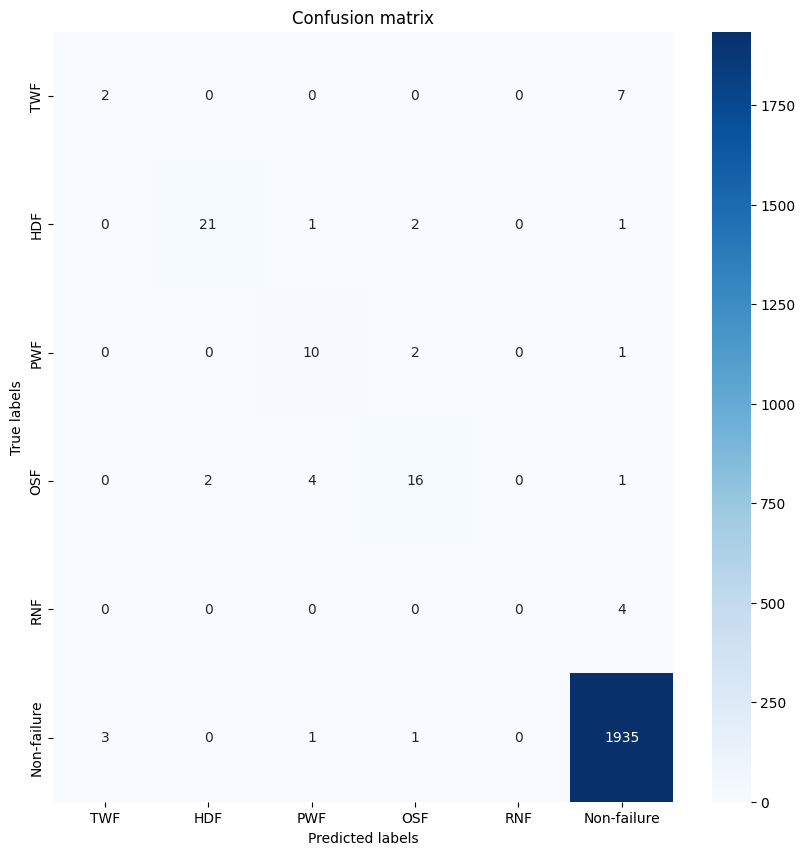

In [10]:
conf_mat = np.zeros((6, 6))

for i in range(6):
    for j in range(6):
        conf_mat[i, j] = np.sum((y_test[:, i] == 1) & (y_pred_dense[:, j] == 1))

label_names = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-failure']

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True,fmt=".0f", cmap='Blues',xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

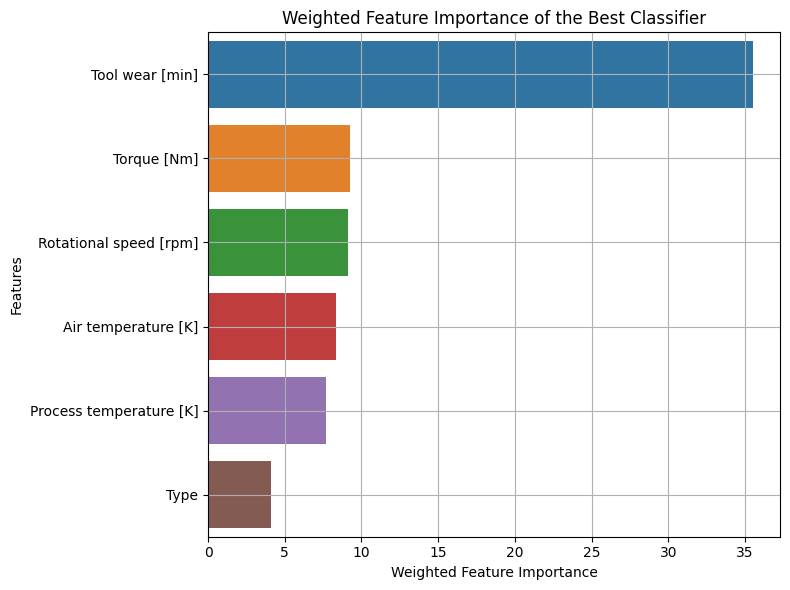

In [18]:
# Get the feature importance of the best classifier
feature_importances = clf.classifiers_[0].feature_importances_

# Weight the feature importance by the support instances of each class
class_support = y_train.sum(axis=0)
weighted_feature_importances = feature_importances * class_support[0]

# Sort the feature importance in descending order
sorted_indices = np.argsort(weighted_feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = weighted_feature_importances[sorted_indices]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the feature importance using seaborn
sns.barplot(x=sorted_importances, y=sorted_features, ax=ax)

# Set the title and labels
ax.set_title("Weighted Feature Importance of the Best Classifier")
ax.set_xlabel("Weighted Feature Importance")
ax.set_ylabel("Features")

# Add a grid and adjust the layout
ax.grid(True)
plt.tight_layout()

# Show the plot
plt.show()